In [81]:
import numpy as np
import matplotlib.pyplot as plt

In [82]:
timecalc = 9
tolerance = 1e-7

# load the data
p_ind_read, frame_read, x_read, y_read = np.genfromtxt(
    "./20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt",
    unpack=True,
)

# data
data = np.array([p_ind_read, frame_read, x_read, y_read])
data = data.T

In [83]:
# print all shapes
print("data.shape", data.shape)
print("data[0] : ", data[0])

data.shape (11579, 4)
data[0] :  [  1.     0.   148.37 108.4 ]


In [84]:
class Nucleosome:
    def __init__(self, p_ind, data):
        self.p_ind = p_ind
        self.traj = self.get_traj(data)
        self.in_time = self.traj[0, 0]
        self.out_time = self.traj[-1, 0]
        
    
    def get_traj(self, data):
        traj = data[data[:, 0] == self.p_ind]
        traj = traj[:, 1:4]                         # have only [frame, x, y]
        return traj
    

1342
(1342,)


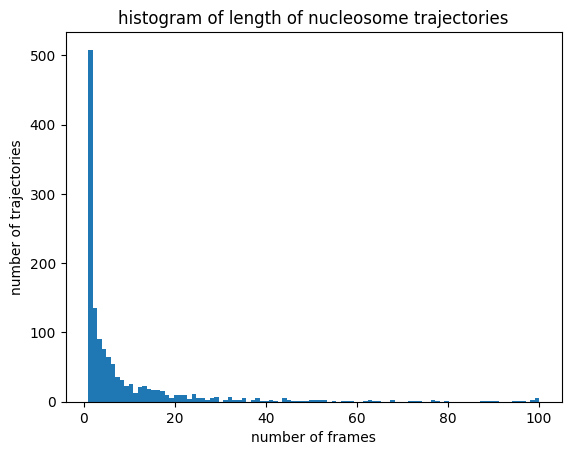

In [85]:
# initialize nucleosomes
nucleosomes = []
for p_ind in np.unique(data[:, 0]):
    nucleosomes.append(Nucleosome(p_ind, data))

hist = []
print(len(nucleosomes))
for nucleosome in nucleosomes:
    if len(nucleosome.traj) > 0:
        hist.append(len(nucleosome.traj))
    # print(len(nucleosome.traj))

hist = np.array(hist)
print(hist.shape)
plt.hist(hist, bins=max(hist))
plt.title("histogram of length of nucleosome trajectories")
plt.xlabel("number of frames")
plt.ylabel("number of trajectories")
plt.show()

In [86]:
# calculate msd for each trajectory which has more than 20 frames
cutoff = 1
msd = []
selected_p_ind = []
stat_rel = 0
for n in nucleosomes:
    if len(n.traj) > cutoff+stat_rel:
        curmsd = np.zeros(cutoff+stat_rel)
        traj = n.traj[:cutoff+stat_rel]
        for i in range(1, cutoff+stat_rel):
            # vectorized
            curmsd[i] = np.sum((traj[i:, 1:3] - traj[0:-i, 1:3])**2) / (cutoff+stat_rel - i)
        msd.append([n.p_ind, curmsd[:cutoff]*4225])    # px^2 to nm^2
        selected_p_ind.append(n.p_ind)
# msd = np.array(msd)
print("msd.shape", len(msd))
print("selected_p_ind.shape", len(selected_p_ind))

msd.shape 834
selected_p_ind.shape 834


In [87]:
# # plot all msd
# # y is log of msd
# # x is log of time
# # np arange 100 frames from 0 s to 5 s
# logy = []
# x = np.log10(np.arange(0, 1.05, 0.05))
# for i in range(len(msd)):
#     # if len(msd[i][1]) > 19:
#     y = np.log10(msd[i][1])   # 4225 nm^2 per pixel^2
#     # y = y[:20]
#     logy.append(y)
#     # selected_p_ind.append(msd[i][0])
#     # plt.plot(msd[i])
#     plt.plot(x[:len(y)], y)
# plt.title("msd of all trajectories")
# plt.xlabel("log(time)")
# plt.ylabel("log(msd in nm^2)")
# plt.ylim(2.5, 5)
# plt.show()

# # plot mean msd of fast nucleosomes
# logy = np.array(logy)
# # select fast as those having msd at 0.75 s > 2*4225 nm^2
# fast = []
# slow = []
# for i in range(len(logy)):
#     if logy[i][15] > np.log10(2*4225):
#         fast.append(logy[i])
#     else:
#         slow.append(logy[i])
# fast = np.array(fast)
# slow = np.array(slow)

# print(fast.shape)

# fastmeany = np.mean(fast, axis=0)
# # faststdy = np.std(fast, axis=0)
# slowmeany = np.mean(slow, axis=0)
# # slowstdy = np.std(slow, axis=0)

# plt.plot(x[:len(fastmeany)], fastmeany, label="fast")
# plt.plot(x[:len(slowmeany)], slowmeany, label="slow")
# plt.title("mean msd of fast and slow nucleosomes")
# plt.xlabel("log(time)")
# plt.ylabel("log(msd in nm^2)")
# plt.legend()
# plt.show()

In [88]:
# print(logy.shape)
# print(logy)

selected_p_ind = np.array(selected_p_ind)
print(selected_p_ind.shape)
print(selected_p_ind)

(834,)
[1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00 7.000e+00
 8.000e+00 9.000e+00 1.000e+01 1.100e+01 1.200e+01 1.300e+01 1.400e+01
 1.500e+01 1.600e+01 1.700e+01 1.800e+01 1.900e+01 2.000e+01 2.100e+01
 2.200e+01 2.300e+01 2.400e+01 2.500e+01 2.600e+01 2.700e+01 2.800e+01
 2.900e+01 3.000e+01 3.100e+01 3.200e+01 3.300e+01 3.400e+01 3.500e+01
 3.600e+01 3.700e+01 3.800e+01 3.900e+01 4.000e+01 4.100e+01 4.200e+01
 4.300e+01 4.400e+01 4.500e+01 4.600e+01 4.700e+01 4.800e+01 4.900e+01
 5.000e+01 5.100e+01 5.200e+01 5.300e+01 5.400e+01 5.500e+01 5.600e+01
 5.700e+01 5.800e+01 5.900e+01 6.000e+01 6.100e+01 6.200e+01 6.300e+01
 6.400e+01 6.500e+01 6.600e+01 6.700e+01 6.800e+01 6.900e+01 7.000e+01
 7.100e+01 7.200e+01 7.300e+01 7.400e+01 7.500e+01 7.600e+01 7.700e+01
 7.800e+01 7.900e+01 8.000e+01 8.100e+01 8.200e+01 8.300e+01 8.400e+01
 8.500e+01 8.600e+01 8.700e+01 8.800e+01 8.900e+01 9.000e+01 9.100e+01
 9.200e+01 9.300e+01 9.400e+01 9.500e+01 9.600e+01 9.700e+01 9.800e+01

In [89]:
# go over each selected trajectory and calculate alpha using polyfit
# new_traj = np.zeros((len(selected_p_ind)*cutoff, 3))   # x,y,t,alpha (before), now x,y,t
# new_traj[:, 2] = np.tile(np.arange(0, 1.0, 0.05), len(selected_p_ind))

# calc the shape of new_traj
entries = 0
for i in range(len(selected_p_ind)):
    p_ind = int(selected_p_ind[i])
    traj = nucleosomes[p_ind-1].traj
    entries += traj.shape[0]

new_traj = np.zeros((entries, 3))

# alpha_analysis = []
cur_ind = 0

for i in range(len(selected_p_ind)):
    # get the x and y of the p_ind
    p_ind = int(selected_p_ind[i])
    traj = nucleosomes[p_ind-1].traj
    # traj = traj[:cutoff]

    new_traj[cur_ind:cur_ind+traj.shape[0], 0] = traj[:, 1]
    new_traj[cur_ind:cur_ind+traj.shape[0], 1] = traj[:, 2]
    new_traj[cur_ind:cur_ind+traj.shape[0], 2] = (traj[:, 0]-traj[0, 0])*0.05       # delta t in seconds

    cur_ind += traj.shape[0]
    # new_traj[cur_ind:cur_ind+traj.shape[0], 2] = np.arange(0, traj.shape[0]*0.05, 0.05)[:traj.shape[0]]

#     new_traj[i*cutoff:(i+1)*cutoff, 0] = traj[:, 1]
#     new_traj[i*cutoff:(i+1)*cutoff, 1] = traj[:, 2]

#     xfull = np.log10(np.arange(0, 1.05, 0.05))
#     # calculate alpha1
#     x1 = xfull[1:6]
#     y1 = logy[i][1:6]
#     alpha1 = 1
#     alpha1, D1 = np.polyfit(x1, y1, 1)

#     print("alpha1", alpha1)

#     # calculate alpha2
#     x2 = xfull[6:20]
#     y2 = logy[i][6:20]
#     alpha2 = 1
#     alpha2, D2 = np.polyfit(x2, y2, 1)
#     print("alpha2", alpha2)
#     print()

#     alpha_analysis.append([alpha1, alpha2])

#     new_traj[i*cutoff:(i+1)*cutoff, 3] = np.concatenate((np.tile(alpha1, 6), np.tile(alpha2, 14)))

print(new_traj.shape)


(11071, 3)


In [90]:
# save the new_traj upto 3 decimal places
np.savetxt("new_traj.txt", new_traj, delimiter="\t", fmt="%.3f")

# save the new_traj as npy
np.save("new_traj.npy", new_traj)

############### note that here, the scheme is x,y,t,alpha (before), now it is x,y,t #####################

# # save the new_traj frame wise in a single file
# with open("new_traj_frame_wise.txt", "w") as f:
#     for i in range(cutoff):
#         for j in range(len(selected_p_ind)):
#             # x,y,alpha,t
#             f.write("%.3f\t%.3f\t%.3f\t%.3f\n" % (new_traj[j*cutoff+i, 0], new_traj[j*cutoff+i, 1], new_traj[j*cutoff+i, 3], new_traj[j*cutoff+i, 2]))
#         # f.write("\n")

# ############### note that here, the scheme is x,y,alpha,t #####################


In [91]:
# # plot the difference between alpha1 and alpha2
# alpha_analysis = np.array(alpha_analysis)
# diff = alpha_analysis[:, 1] - alpha_analysis[:, 0]
# plt.hist(diff, bins=30)
# plt.title("alpha2 - alpha1")
# plt.xlabel("difference")
# plt.ylabel("number of trajectories")
# plt.show()

In [92]:
# # plot the alpha1 and alpha2
# plt.scatter(alpha_analysis[:, 0], alpha_analysis[:, 1])
# plt.xlabel("alpha1")
# plt.ylabel("alpha2")
# plt.title("alpha1 vs alpha2")
# # plot x=y line
# plt.plot([-0.25, 1], [-0.75, 1], color="red")
# plt.show()